# Guide to Handling Missing Data and Outliers

- [Section 1: Handling Missing Data](#1:-Handling-Missing-Data)
    - [Types of Missing data](#1.1-Types-of-Missing-Data)
    - [Detecting Missing Data](#1.2-Detecting-Missing-Data)
    - [Visualising Missing Data](#1.3-Visualising-Missing-Data)
    - [Handling Missing Data](#1.4-Handling-Missing-Data)
- [Section 2: Handling Outliers](#Section-2:-Handling-Outliers)
    - [Identifying Outliers](#2.1-Identifying-Outliers)
    - [Handling Outliers](#2.2-Handling-Outliers)

This notebook covers techniques for identifying and handling missing data and outliers in datasets. 

## Section 1: Handling Missing Data

### 1.1 Types of Missing Data
- **MCAR (Missing Completely at Random)**: No relationship between the missing data and any other values.
- **MAR (Missing at Random)**: Missing data is related to other observed variables.
- **MNAR (Missing Not at Random)**: Missing data is related to the missing values themselves.


### 1.2 Detecting Missing Data
You can use `.isnull()` and `.isna()` to identify missing data in Python.

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
# Load dataset
df = sns.load_dataset('titanic')

# Check for missing values
missing_data = df.isnull().sum()
print(missing_data)

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64


### 1.3 Visualising Missing Data

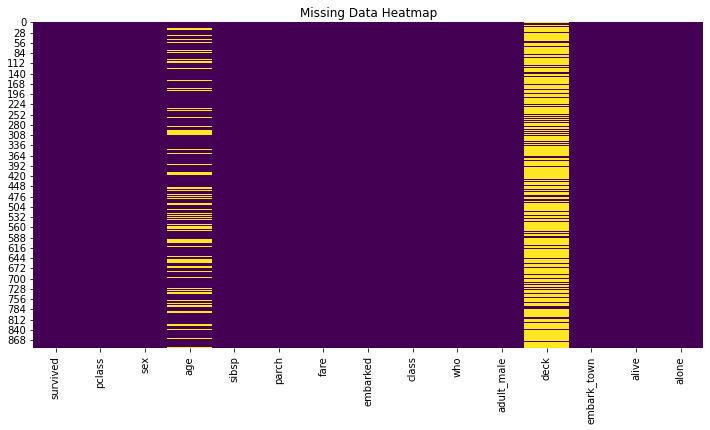

In [16]:
# Visualize missing data using a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

### 1.4 Handling Missing Data
#### Dropping Missing Data
One simple approach is to drop rows or columns that contain missing values.

In [32]:
# Dropping rows with missing values
df_dropped_rows = df.dropna()

# Dropping columns with missing values
df_dropped_columns = df.dropna(axis=1)

# Check the shape of the new datasets
print(f"Original shape: {df.shape}")
print(f"Rows dropped shape: {df_dropped_rows.shape}")
print(f"Columns dropped shape: {df_dropped_columns.shape}")

Original shape: (891, 15)
Rows dropped shape: (201, 15)
Columns dropped shape: (891, 12)


#### Imputing Missing Data:
**Mean/Median/Mode Imputation**:

In [33]:
# Impute missing values
df_filled = df_dropped.fillna({
    'age': df_dropped['age'].median(), # Median imputation for numerical column
    'fare': df_dropped['fare'].mean(), # Mean imputation for numerical column
    'embarked': df_dropped['embarked'].mode()[0]  # Mode imputation for categorical column
})

# Verify missing values after handling
df_filled.isnull().sum()

survived       0
pclass         0
sex            0
age            0
sibsp          0
parch          0
fare           0
embarked       0
class          0
who            0
adult_male     0
deck           0
embark_town    0
alive          0
alone          0
dtype: int64

**KNN Imputation** <br>
KNN imputation (K-Nearest Neighbors imputation) is a method used to fill in missing values in a dataset based on the values of the nearest neighbors. KNN is distance-based and works best with numerical data so you must encode the categorical features into numerical format before applying the imputer. <br>

The two most common techniques for encoding categorical features are Label encoding and one-hot encoding. 
- Label Encoding: For ordinal features (features with an inherent order like Pclass).
- One-Hot Encoding: For nominal features (features with no inherent order like Sex or Embarked).



In [29]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Separate the features into numerical and categorical
numerical_features = ['age', 'fare', 'sibsp', 'parch']  
categorical_features = ['pclass', 'sex', 'embarked']   

# Handle categorical data using encoding 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Create a pipeline for transformation and imputation
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('imputer', KNNImputer(n_neighbors=5))  # You can adjust n_neighbors
])

# Fit and transform the dataset
df_imputed = pipeline.fit_transform(df)

# Convert the imputed numpy array back to a DataFrame
df_imputed = pd.DataFrame(df_imputed, columns=numerical_features + list(pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out()))

In [31]:
df_imputed.head()

,age,fare,sibsp,parch,pclass_1,pclass_2,pclass_3,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,embarked_nan
0,22.0,7.2500,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,38.0,71.2833,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,26.0,7.9250,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,35.0,53.1000,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,35.0,8.0500,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


## Section 2: Handling Outliers

### 2.1 Identifying Outliers
Outliers can be identified using various techniques:

- Box Plots
- Z-score Method
- Interquartile Range (IQR

#### Box Plots

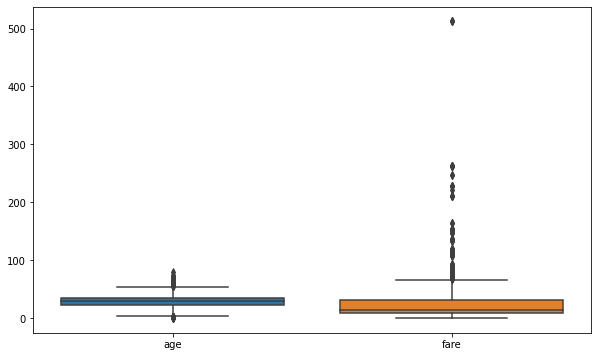

In [36]:
# Box plot for numerical features
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['age', 'fare']])
plt.show()

#### Z-Score Method
The Z-score tells us how many standard deviations a given value is from the mean. 
Interpretation: 
- A Z-score of 1 means the value is 1 standard deviation above the mean.
- A Z-score of -1 means the value is 1 standard deviation below the mean.
- Z-scores beyond ±2 or ±3 often indicate that the data point is significantly higher or lower than the average and could be considered an outlier.

In [43]:
from scipy import stats

# Calculate the z-scores for 'Fare'
df['Fare_zscore'] = np.abs(stats.zscore(df['fare']))

# Find outliers with z-score > 3
outliers = df[df['Fare_zscore'] > 3]
outliers.head()


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,Fare_zscore
27,0,1,male,19.0,3,2,263.0000,S,First,man,True,C,Southampton,no,False,4.647001
88,1,1,female,23.0,3,2,263.0000,S,First,woman,False,C,Southampton,yes,False,4.647001
118,0,1,male,24.0,0,1,247.5208,C,First,man,True,B,Cherbourg,no,False,4.335332
258,1,1,female,35.0,0,0,512.3292,C,First,woman,False,NaN,Cherbourg,yes,True,9.667167
299,1,1,female,50.0,0,1,247.5208,C,First,woman,False,B,Cherbourg,yes,False,4.335332


#### Interquartile Range (IQR)
The IQR method defines outliers as data points outside of 1.5 times the IQR.

In [42]:
# Calculate IQR for 'Fare'
Q1 = df['fare'].quantile(0.25)
Q3 = df['fare'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers_iqr = df[(df['fare'] < lower_bound) | (df['fare'] > upper_bound)]
outliers_iqr.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,Fare_zscore
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False,0.786845
27,0,1,male,19.0,3,2,263.0000,S,First,man,True,C,Southampton,no,False,4.647001
31,1,1,female,NaN,1,0,146.5208,C,First,woman,False,B,Cherbourg,yes,False,2.301729
34,0,1,male,28.0,1,0,82.1708,C,First,man,True,NaN,Cherbourg,no,False,1.006062
52,1,1,female,49.0,1,0,76.7292,C,First,woman,False,D,Cherbourg,yes,False,0.896497


### 2.2 Handling Outliers
- Removing Outliers
- Capping/Flooring Outliers
- Transformation Techniques
#### Removing Outliers:

In [44]:
# Remove outliers based on IQR method
df_no_outliers = df[(df['fare'] >= lower_bound) & (df['fare'] <= upper_bound)]
df_no_outliers.shape


(775, 16)

#### Capping and Flooring
Instead of removing outliers, you can cap them at a threshold.

In [47]:
# Cap 'Fare' at the upper and lower bounds
df['Fare_capped'] = df['fare'].apply(lambda x: upper_bound if x > upper_bound else (lower_bound if x < lower_bound else x))
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,Fare_zscore,Fare_capped
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False,0.502445,7.2500
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False,0.786845,65.6344
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True,0.488854,7.9250
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False,0.420730,53.1000
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True,0.486337,8.0500


#### Log transformation
Log transformation can reduce the effect of outliers and skewed distributions.
- np.log(df['column']): Use this when you are certain that the column contains only positive values and no zeros or negative numbers.

- np.log1p(df['Fare']): Use this when the column might contain zeros or small positive values. This method is numerically stable for data close to zero and avoids issues with -inf.

In [49]:
# Log transformation for 'Fare'
df['Fare_log'] = np.log1p(df['fare'])
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,Fare_zscore,Fare_capped,Fare_log
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False,0.502445,7.2500,2.110213
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False,0.786845,65.6344,4.280593
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True,0.488854,7.9250,2.188856
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False,0.420730,53.1000,3.990834
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True,0.486337,8.0500,2.202765


## Conclusion

In this notebook, we've explored different techniques to handle missing data and outliers:
1. For missing data, we covered methods such as dropping rows/columns and imputation.
2. For outliers, we demonstrated detection using Z-score and IQR, and how to handle them via removal or transformation.
